# Structured Time Series with TF Probability
We will be using the total female births per year dataset to explore structured time series' in TFP.

Example is modelled on the example from this <a href ="https://medium.com/tensorflow/structural-time-series-modeling-in-tensorflow-probability-344edac24083">article</a> and the associated <a href = "https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb">code</a>.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import sts

In [17]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [18]:
def build_model(observed_time_series):
    
    trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
    seasonal = tfp.sts.Seasonal(num_seasons=12, observed_time_series=observed_time_series)
    model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
    
    return model

In [22]:
filepath = "/media/greg/Storage/datasets/time_series/daily_total_female_births/daily-total-female-births.csv"
df = pd.read_csv(filepath)

print(df.head())

         Date  Births
0  1959-01-01      35
1  1959-01-02      32
2  1959-01-03      30
3  1959-01-04      31
4  1959-01-05      44


In [23]:
births_ts = df.Births.astype(np.float) # TFP requires us to work with floats.
birth_dates = df.Date.values

model = build_model(births_ts)

# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=model)

Instructions for updating:
SeedStream has moved to `tfp.util.SeedStream`.


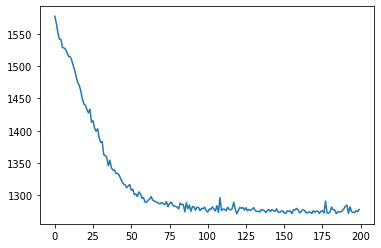

In [25]:
#@title Minimize the variational loss.

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 200 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)
# Using fit_surrogate_posterior to build and optimize the variational loss function.
def train():
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=model.joint_log_prob(
        observed_time_series=births_ts),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
  return elbo_loss_curve

elbo_loss_curve = train()

plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples_births_ = variational_posteriors.sample(50)

In [27]:
print("Inferred parameters:")
for param in model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_births_[param.name], axis=0),
                              np.std(q_samples_births_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 6.492300417534741 +- 0.18992896957956024
LocalLinearTrend/_level_scale: 0.32214757160928414 +- 0.10951441580872576
LocalLinearTrend/_slope_scale: 0.01586770343301735 +- 0.01515068428421647
Seasonal/_drift_scale: 0.15067976365308783 +- 0.1329654011483034


In [29]:
num_forecast_steps = 10


births_forecast_dist = tfp.sts.forecast(
    model,
    observed_time_series=births_ts,
    parameter_samples=q_samples_births_,
    num_steps_forecast=num_forecast_steps)

In [30]:
num_samples=10

births_forecast_mean, births_forecast_scale, births_forecast_samples = (
    births_forecast_dist.mean().numpy()[..., 0],
    births_forecast_dist.stddev().numpy()[..., 0],
    births_forecast_dist.sample(num_samples).numpy()[..., 0])

In [ ]:
fig, ax = plot_forecast(
    birth_dates, births_ts,
    births_forecast_mean, births_forecast_scale, births_forecast_samples,
    x_locator=co2_loc,
    x_formatter=co2_fmt,
    title="Atmospheric CO2 forecast")
ax.axvline(co2_dates[-num_forecast_steps], linestyle="--")
ax.legend(loc="upper left")
ax.set_ylabel("Atmospheric CO2 concentration (ppm)")
ax.set_xlabel("Year")
fig.autofmt_xdate()